## SNIPPET 6.1 Generating a Set of Informed, Redundant, and Noise Explanatory Variables

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.discrete.discrete_model as sm


In [2]:
def getTestData(n_features=100, n_informative=25, n_redundant=25, n_samples=10000, random_state=0, sigmaStd=0.) :
    # Generate a random dataset for a claasification problem
    
    from sklearn.datasets import make_classification
    np.random.seed(random_state)
    
    X, y = make_classification(n_samples = n_samples,
                                n_features = n_features - n_redundant, 
                                n_informative = n_informative, 
                                n_redundant = 0,
                                shuffle = False,
                                random_state = random_state)
    
    cols = ['I_'+str(i) for i in range(n_informative)]
    cols += ['N_' + str(i) for i in range(n_features - n_informative - n_redundant)]
    
    X, y = pd.DataFrame(X, columns = cols), pd.Series(y)
    
    i = np.random.choice(range(n_informative), size = n_redundant)
    
    for k,j in enumerate(i) :
        X['R_' + str(k)] = X['I_' + str(j)] + np.random.normal(size = X.shape[0]) * sigmaStd
        
    return X, y


In [3]:
X, y = getTestData(40, 5, 30, 10000, sigmaStd=.1)
ols = sm.Logit(y,X).fit()
ols.summary()

Optimization terminated successfully.
         Current function value: 0.380271
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9960
Method:                           MLE   Df Model:                           39
Date:                Tue, 04 Aug 2020   Pseudo R-squ.:                  0.4514
Time:                        00:01:34   Log-Likelihood:                -3802.7
converged:                       True   LL-Null:                       -6931.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
I_0            1.5619      0.814      1.918      0.055      -0.034       3.158
I_1           -2.3691      0.709     -3.343      0.001      -3.758      -0.980
I_2            0.8641      0.504      1.715      0.086      -0.123       1.851
I_3            1.8296      0.860      2.128      0.033       0.145       3.514
I_4           -0.4776      0.567     -0.842      0.400      -1.590       0.635
N_0            0.0244      0.028      0.857      0.391      -0.031       0.080
N_1           -0.0485      0.029     -1.671      0.095      -0.105       0.008
N_2            0.0367      0.029      1.262      0.207      -0.020       0.094
N_3           -0.0205      0.029     -0.706      0.480      -0.077       0.036
N_4           -0.0421      0.029     -1.459      0.145      -0.099       0.014
R_0            0.0271      0.287      0.094      0.925      -0.535       0.589
R_1           -0.0619      0.286     -0.216      0.829      -0.623       0.499
R_2            0.1759      0.286      0.616      0.538      -0.384       0.736
R_3           -0.3816      0.288     -1.326      0.185      -0.946       0.182
R_4           -0.0886      0.289     -0.307      0.759      -0.655       0.478
R_5            0.0035      0.286      0.012      0.990      -0.556       0.563
R_6           -0.1685      0.287     -0.587      0.557      -0.732       0.395
R_7           -0.0064      0.287     -0.022      0.982      -0.570       0.557
R_8           -0.3122      0.289     -1.080      0.280      -0.879       0.255
R_9           -0.4787      0.292     -1.637      0.102      -1.052       0.094
R_10          -0.2420      0.288     -0.840      0.401      -0.807       0.323
R_11           0.2955      0.286      1.034      0.301      -0.265       0.856
R_12          -0.0285      0.296     -0.096      0.923      -0.609       0.552
R_13           0.3914      0.288      1.360      0.174      -0.173       0.955
R_14          -0.2370      0.290     -0.817      0.414      -0.805       0.331
R_15           0.1278      0.292      0.438      0.661      -0.444       0.699
R_16          -0.1507      0.290     -0.520      0.603      -0.719       0.417
R_17          -0.5064      0.288     -1.757      0.079      -1.071       0.059
R_18           0.2050      0.288      0.711      0.477      -0.360       0.770
R_19          -0.0950      0.288     -0.330      0.741      -0.659       0.469
R_20          -0.2437      0.286     -0.851      0.395      -0.805       0.317
R_21          -0.0479      0.293     -0.163      0.870      -0.623       0.527
R_22           0.1300      0.287      0.452      0.651      -0.433       0.693
R_23           0.4978      0.291      1.713      0.087      -0.072       1.067
R_24          -0.2049      0.290     -0.706      0.480      -0.774       0.364
R_25          -0.0985      0.289     -0.341      0.733      -0.665       0.468
R_26          -0.2239      0.289     -0.776      0.438      -0.789       0.342
R_27           0.6949      0.289      2.406      0.016       0.129       1.261
R_

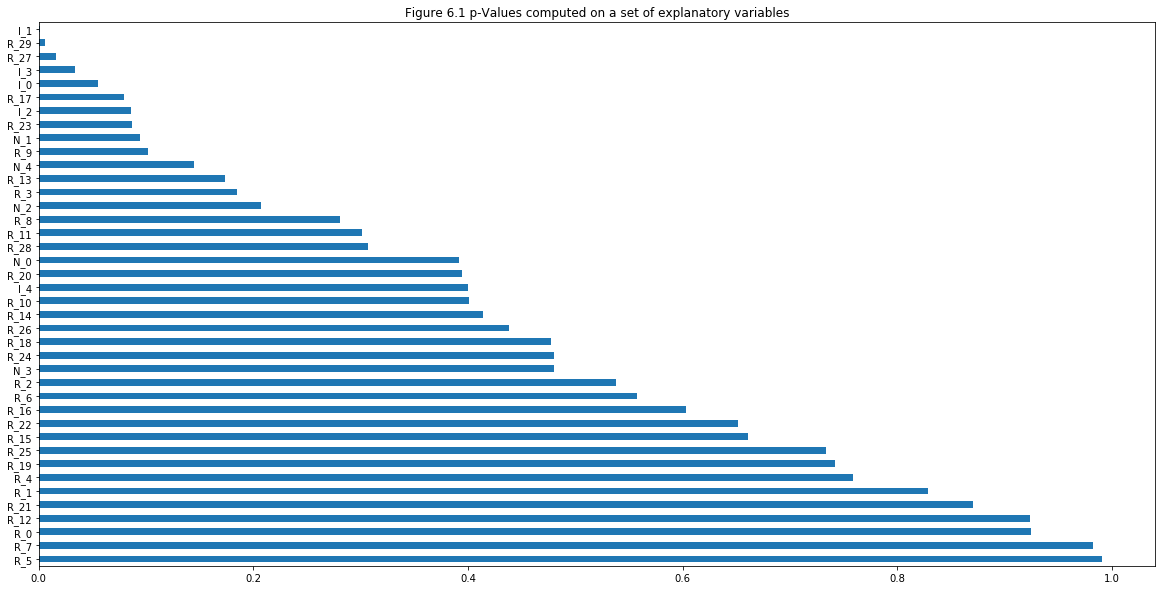

In [4]:
plot_data = ols.pvalues.sort_values(ascending=False)
plot_data.plot(kind='barh', figsize=(20,10), title="Figure 6.1 p-Values computed on a set of explanatory variables")
plt.show()

## SNIPPET 6.2 Implementation of an Ensemble MDI Method

In [5]:
def featImpMDI(fit, featNames) :
    
    # feat imoprtance based on IS mean impurity reduction
    
    df0 = {i : tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    
    df0.columns = featNames
    df0= df0.replace(0, np.nan) # because max_features=1
    
    imp = pd.concat({'mean' : df0.mean(), 'std':df0.std() * df0.shape[0]**-.5}, axis=1) #CLT
    
    imp /= imp['mean'].sum()
    return imp


In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

X, y = getTestData(40, 5, 30, 10000, sigmaStd=.1)

In [26]:
clf = DecisionTreeClassifier(criterion='entropy', 
                             max_features = 1, 
                             class_weight='balanced', 
                             min_weight_fraction_leaf=0)

clf = BaggingClassifier(base_estimator=clf, 
                        n_estimators = 1000, 
                        max_features = 1., 
                        max_samples = 1., 
                        oob_score=False)

fit = clf.fit(X,y)
imp = featImpMDI(fit, featNames=X.columns)

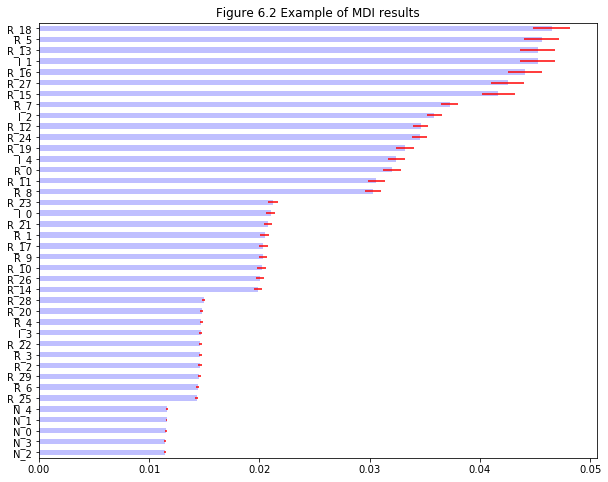

In [27]:
imp.sort_values('mean', inplace=True)
plt.figure(figsize=(10, imp.shape[0] / 5))
imp['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=imp['std'], error_kw={'ecolor': 'r'})
plt.title('Figure 6.2 Example of MDI results')
plt.show()

## SNIPPET 6.3 Implementation of MDA

In [16]:
def featImpMDA(clf, X, y, n_splits=10) :
    # feat importance based on OOS score reduction
    
    from sklearn.metrics import log_loss
    from sklearn.model_selection._split import KFold
    cvGen = KFold(n_splits = n_splits)
    scr0, scr1 = pd.Series(), pd.DataFrame(columns=X.columns)
    
    for i, (train, test) in enumerate(cvGen.split(X=X)) :
        X0, y0 = X.iloc[train, :], y.iloc[train]
        X1, y1 = X.iloc[test, :], y.iloc[test]
        fit = clf.fit(X=X0, y=y0)  # the fit occurs here
        
        prob = fit.predict_proba(X1) # prediction before shuffling
        scr0.loc[i] = -log_loss(y1, prob, labels=clf.classes_)
        
        for j in X.columns :
            X1_ = X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # shuffle one column
            prob = fit.predict_proba(X1_)  # prediction after shuffling
            scr1.loc[i,j] = -log_loss(y1, prob, labels=clf.classes_)
    
    imp = (-1 * scr1).add(scr0, axis=0)
    imp /= -1 * scr1
    imp = pd.concat( {'mean' : imp.mean(),
                     'std' : imp.std() * imp.shape[0]**-.5}, axis=1)   #CLT
    return imp

In [18]:
X,y = getTestData(40, 5, 30, 10000, sigmaStd = .1)

clf = DecisionTreeClassifier(criterion = 'entropy',
                            max_features = 1,
                            class_weight = 'balanced',
                            min_weight_fraction_leaf = 0)

clf = BaggingClassifier(base_estimator = clf,
                        n_estimators = 1000,
                        max_features = 1.,
                        max_samples = 1.,
                        oob_score = False)

imp = featImpMDA(clf, X, y, 10)

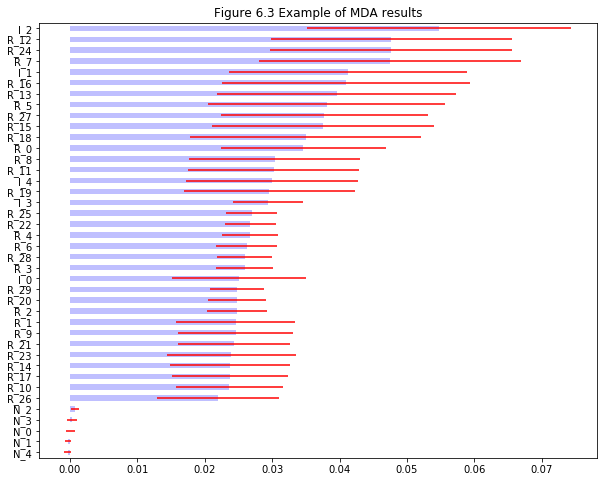

In [21]:
imp.sort_values('mean', inplace=True)
plt.figure(figsize=(10, imp.shape[0] / 5))
imp['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=imp['std'], error_kw={'ecolor': 'r'})
plt.title('Figure 6.3 Example of MDA results')
plt.show()

## SNIPPET 6.4 Clustered MDI

In [48]:
def groupMeanStd(df0, clstrs) :
    
    out = pd.DataFrame(columns=['mean','std'])
    
    for i, j in clstrs.items():
        df1 = df0[j].sum(axis=1)
        out.loc['C_' + str(i), 'mean'] = df1.mean()
        out.loc['C_' + str(i), 'std'] = df1.std() * df1.shape[0]**-.5
    
    return out

def featImpMDI_Clustered(fit, featNames, clstrs) :
    df0 = {i:tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    df0.columns = featNames
    df0 = df0.replace(0, np.nan)  # because max_features = 1
    
    imp = groupMeanStd(df0, clstrs)
    imp /= imp['mean'].sum()

    return imp

## SNIPPET 6.5 Clustered MDA

In [31]:
def featImpMDA_Clustered(clf,X,y,clstrs,n_splits=10):
    from sklearn.metrics import log_loss
    from sklearn.model_selection._split import KFold
    
    cvGen = KFold(n_splits = n_splits)
    scr0, scr1 = pd.Series(), pd.DataFrame(columns=clstrs.keys())
    
    for i, (train, test) in enumerate(cvGen.split(X=X)) :
        X0, y0 = X.iloc[train, :], y.iloc[train]
        X1, y1 = X.iloc[test, :], y.iloc[test]
        fit = clf.fit(X=X0, y=y0)
        prob = fit.predict_proba(X1)
        
        scr0.loc[i] = -log_loss(y1, prob, labels=clf.classes_)
        
        for j in scr1.columns :
            X1_ = X1.copy(deep=True)
            
            for k in clstrs[j]:
                np.random.shuffle(X1_[k].values) # shuffle clusters
            
            prob = fit.predict_proba(X1_)
            scr1.loc[imj] = -log_loss(y1, prob, labels=clf.classes_)
            
    imp = (-1 * scr1).add(scr0, axis=0)
    imp /= -1 * scr1
    imp = pd.concat({'mean' : imp.mean(),
                    'std' : imp.std() * imp.shape[0]**-.5}, axis=1)
    imp.index = ['C_' + str(i) for i in imp.index]

    return imp

## SNIPPET 6.6 Features Clustering Step

### Define SNIPPET 4.1

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

def clusterKMeansBase(corr0, maxNumClusters = 10, n_init = 10) :

    x = ((1-corr0.fillna(0))/2)**0.5
    silh = pd.Series()   # Observations matrix
    
    for init in range(n_init) :
        for i in range (2, maxNumClusters +1) :
            kmeans_ = KMeans(n_clusters = i, n_jobs=1, n_init=1)
            kmeans_ = kmeans_.fit(x)
            
            silh_ = silhouette_samples(x, kmeans_.labels_)
            stat = (silh_.mean() / silh_.std(), silh.mean()/silh.std())
            
            if np.isnan(stat[1]) or stat[0] > stat[1] :
                silh = silh_
                kmeans = kmeans_
    
    # Reordering
    newIdx = np.argsort(kmeans.labels_)
    corr1 = corr0.iloc[newIdx] # reorder rows
    corr1 = corr1.iloc[:, newIdx] # reorder columns
    
    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() \
             for i in np.unique(kmeans.labels_)}  # cluster members
    silh = pd.Series(silh, index = x.index)
    
    return corr1, clstrs, silh
    

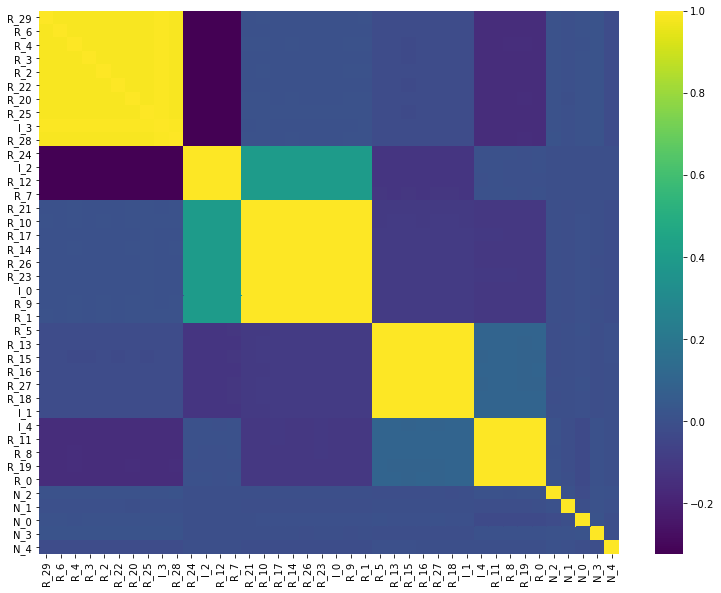

In [42]:
X, y = getTestData(40, 5, 30, 10000, sigmaStd=.1)
corr0, clstrs, silh = clusterKMeansBase(X.corr(), maxNumClusters=10, n_init=10)

fig, ax = plt.subplots(figsize=(13,10))       
sns.heatmap(corr0, cmap='viridis')
plt.show()

## SNIPPET 6.7 Calling the Functions for Clusterd MDI

In [45]:
clstrs

{0: ['I_3',
  'R_2',
  'R_3',
  'R_4',
  'R_6',
  'R_20',
  'R_22',
  'R_25',
  'R_28',
  'R_29'],
 1: ['I_2', 'R_7', 'R_12', 'R_24'],
 2: ['I_0', 'R_1', 'R_9', 'R_10', 'R_14', 'R_17', 'R_21', 'R_23', 'R_26'],
 3: ['I_1', 'R_5', 'R_13', 'R_15', 'R_16', 'R_18', 'R_27'],
 4: ['I_4', 'R_0', 'R_8', 'R_11', 'R_19'],
 5: ['N_0', 'N_1', 'N_2', 'N_3', 'N_4']}

In [49]:
clf = DecisionTreeClassifier(criterion = 'entropy', 
                             max_features=1,
                             class_weight = 'balanced',
                             min_weight_fraction_leaf = 0)

clf = BaggingClassifier(base_estimator = clf,
                       n_estimators = 1000,
                       max_features = 1.,
                       max_samples = 1.,
                       oob_score = False)

fit = clf.fit(X, y)

imp = featImpMDI_Clustered(fit, X.columns, clstrs)

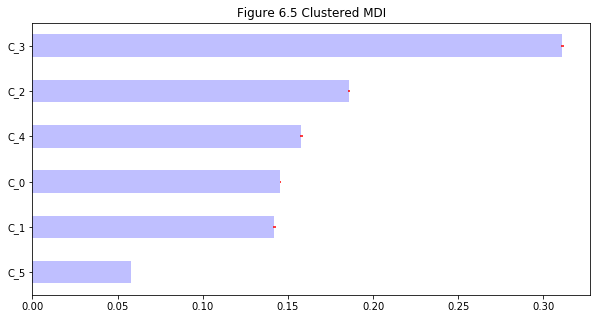

In [52]:
imp.sort_values('mean', inplace=True)
plt.figure(figsize=(10, 5))
imp['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=imp['std'], error_kw={'ecolor': 'r'})
plt.title('Figure 6.5 Clustered MDI')
plt.show()